In [56]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import scipy.stats as ss
from arch import arch_model

In [38]:
prices = yf.download('USDRUB=X', '2016-01-08', '2019-01-01')
prices.index = prices.index.to_period(freq='d')
prices

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-07,75.489502,75.489502,74.684998,74.595001,74.595001,0
2016-01-08,75.489502,75.489502,74.089996,74.595001,74.595001,0
2016-01-11,75.975998,76.131897,75.052002,74.794998,74.794998,0
2016-01-12,76.901001,76.901001,75.873802,76.001999,76.001999,0
2016-01-13,76.633003,76.653999,75.733002,76.525002,76.525002,0
...,...,...,...,...,...,...
2018-12-25,68.611504,68.926903,68.168503,68.613800,68.613800,0
2018-12-26,68.720497,69.434998,68.491997,68.720398,68.720398,0
2018-12-27,68.648201,69.664001,68.348999,68.647903,68.647903,0


In [39]:
returns = prices['Close'].pct_change().dropna()
returns


Date
2016-01-08    0.000000
2016-01-11    0.002681
2016-01-12    0.016137
2016-01-13    0.006881
2016-01-14   -0.004077
                ...   
2018-12-25   -0.001557
2018-12-26    0.001554
2018-12-27   -0.001055
2018-12-28    0.013246
2018-12-31   -0.000517
Freq: D, Name: Close, Length: 775, dtype: float64

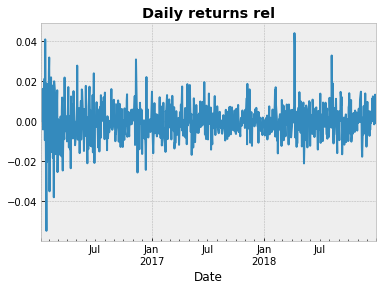

In [40]:
returns.plot()
plt.title("Daily returns rel", weight="bold")

plt.show()

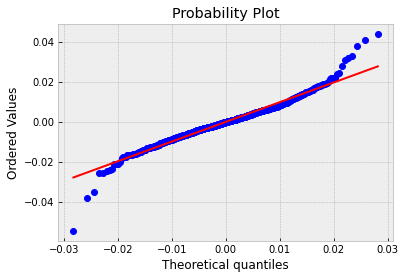

In [41]:
params_norm = ss.norm.fit(returns)
ss.probplot(returns, dist=ss.norm(*params_norm), plot=plt)
plt.show()
#probplot -- eto qq plot
#distplot -- hist

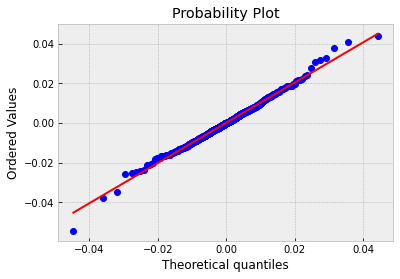

In [46]:
params_t = ss.t.fit(returns)
ss.probplot(returns, dist=ss.t(*params_t), plot=plt)
plt.show()

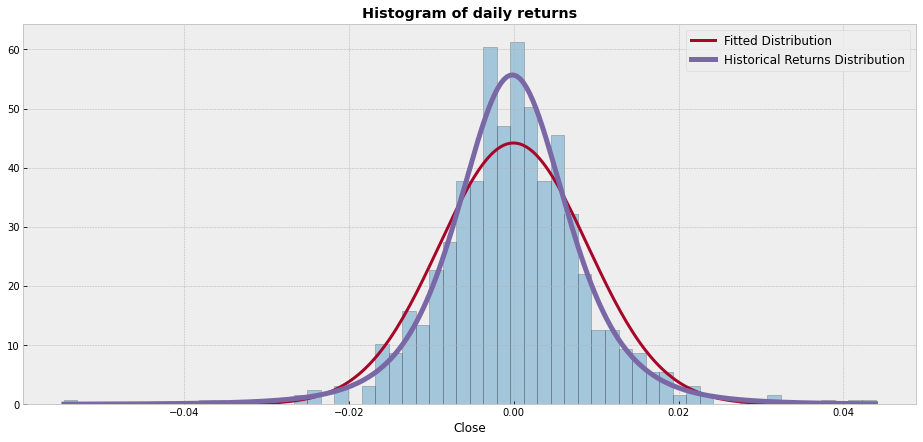

In [45]:
x = np.linspace(returns.min(), returns.max(), 252)

y_pdf = ss.norm.pdf(x, *params_norm)
y_t_pdf = ss.t.pdf(x, *params_t)
plt.figure(figsize=(16,7))

sns.distplot(returns, hist=True, kde=False,
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)
plt.plot(x, y_t_pdf, linewidth=5)


plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)

plt.show()

In [64]:
def filter_garch(returns, alpha = 0.05, dist = 'skewstudent', mean = 'HARX', vol = 'Garch'):
    scaling_const = 10.0 / returns.std()

    am = arch_model(scaling_const * returns,
                    mean=mean, lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol=vol, p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    # forecasts = res.forecast(horizon=1)
    #
    # cond_mean = forecasts.mean
    # cond_var = forecasts.variance

    # if dist == 'Normal':
    #     q = am.distribution.ppf(alpha)
    # elif dist == 't' or dist == 'ged':
    #     q = am.distribution.ppf(alpha, res.params[-1:])
    # elif dist == 'skewstudent':
    #     q = am.distribution.ppf(alpha, res.params[-2:])

    # return_garch_forecast = cond_mean / scaling_const
    # VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
    stand_residuals = res.resid / res.conditional_volatility
    return stand_residuals.dropna()

In [65]:
filtered_returns = filter_garch(returns)

In [66]:
filtered_returns

Date
2016-01-11    0.135487
2016-01-12    0.850409
2016-01-13    0.385918
2016-01-14   -0.210326
2016-01-15    0.046831
                ...   
2018-12-25   -0.188087
2018-12-26    0.194819
2018-12-27   -0.146372
2018-12-28    1.817313
2018-12-31   -0.023024
Freq: D, Length: 774, dtype: float64

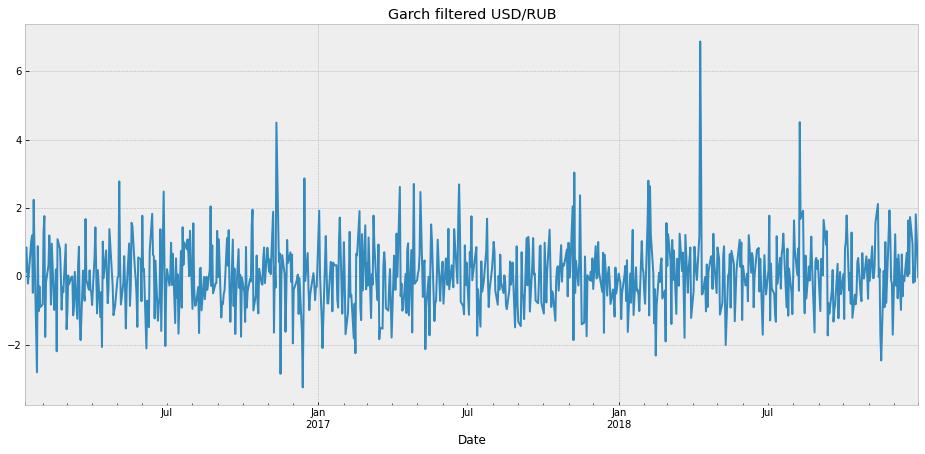

In [73]:
plt.figure(figsize=(16,7))
filtered_returns.plot()
plt.title("Garch filtered USD/RUB")
plt.savefig("usd_rub_close_garch_filtered.pdf")
plt.show()

In [68]:
from statsmodels.tsa.stattools import adfuller
X = filtered_returns.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.180081
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
